# Steel Defect Detection using U-Net 
## Dataset: [Severstal: Steel Defect Detection](https://www.kaggle.com/competitions/severstal-steel-defect-detection)

In [1]:
# Importing necessary libraries and csv data
import numpy as np, pandas as pd, os, gc
import matplotlib.pyplot as plt, time
from PIL import Image 
import warnings
warnings.filterwarnings("ignore")

path = '../input/severstal-steel-defect-detection/'
train = pd.read_csv(path + 'train.csv')

In [2]:
# Understanding train data
train

ImageId  ClassId  \
0     0002cc93b.jpg        1   
1     0007a71bf.jpg        3   
2     000a4bcdd.jpg        1   
3     000f6bf48.jpg        4   
4     0014fce06.jpg        3   
...             ...      ...   
7090  ffcf72ecf.jpg        3   
7091  fff02e9c5.jpg        3   
7092  fffe98443.jpg        3   
7093  ffff4eaa8.jpg        3   
7094  ffffd67df.jpg        3   

                                          EncodedPixels  
0     29102 12 29346 24 29602 24 29858 24 30114 24 3...  
1     18661 28 18863 82 19091 110 19347 110 19603 11...  
2     37607 3 37858 8 38108 14 38359 20 38610 25 388...  
3     131973 1 132228 4 132483 6 132738 8 132993 11 ...  
4     229501 11 229741 33 229981 55 230221 77 230468...  
...                                                 ...  
7090  121911 34 122167 101 122422 169 122678 203 122...  
7091  207523 3 207777 9 208030 15 208283 22 208537 2...  
7092  105929 5 106177 14 106424 24 106672 33 106923 ...  
7093  16899 7 17155 20 17411 34 17667 47 17923 60 18...  
7094  30931 43 31103 127 31275 211 31489 253 31745 2...  

[7095 rows x 3 columns]

In [3]:
# Restructing the train dataframe
train1 = train.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
train1.reset_index(inplace=True)
train2 = pd.DataFrame({'ImageId': train1['ImageId'], 'e1': train1[1], 'e2': train1[2], 'e3': train1[3], 'e4': train1[4]})
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values
train2.head()

ImageId                                                 e1 e2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...      
1  0007a71bf.jpg                                                         
2  000a4bcdd.jpg  37607 3 37858 8 38108 14 38359 20 38610 25 388...      
3  000f6bf48.jpg                                                         
4  0014fce06.jpg                                                         

                                                  e3  \
0                                                      
1  18661 28 18863 82 19091 110 19347 110 19603 11...   
2                                                      
3                                                      
4  229501 11 229741 33 229981 55 230221 77 230468...   

                                                  e4  count  
0                                                         1  
1                                                         1  
2                                                         1  
3  131973 1 132228 4 132483 6 132738 8 132993 11 ...      1  
4                                                         1

In [4]:
# Using Keras data generator
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

Using TensorFlow backend.


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1572747266418118938
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16132370907999495015
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17589671280517939006
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15878337332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9796280667606193831
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [6]:
def rle2maskResize(rle):
    """
    Convert run length encoding to mask
    """
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

In [7]:
def mask2contour(mask, width=3):
    """
    Convert mask to its contour
    """
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3)

In [8]:
def mask2pad(mask, pad=2):
    """
    Enlarge Mask to include more space around the defect
    """
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

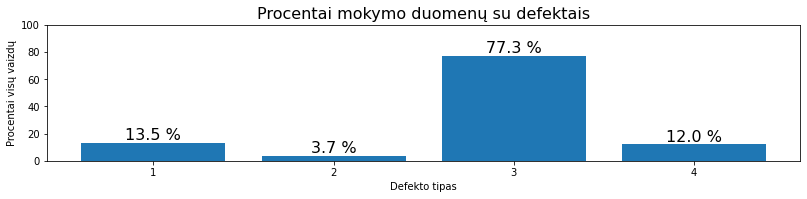

In [9]:
plt.figure(figsize=(13.5,2.5))
bar = plt.bar( [1,2,3,4],100*np.mean( train2.iloc[:,1:5]!='',axis=0) )
plt.title('Procentai mokymo duomenų su defektais', fontsize=16)
plt.ylabel('Procentai visų vaizdų'); plt.xlabel('Defekto tipas')
plt.xticks([1,2,3,4])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=16)
plt.ylim((0,100)); plt.show()

We see that most (77.3%) of the images have Type 3 defect.

In [10]:
# DEFECTIVE IMAGE SAMPLES
filenames = {}
defects = list(train2[train2['e1']!=''].sample(3).index)
defects += list(train2[train2['e2']!=''].sample(3).index)
defects += list(train2[train2['e3']!=''].sample(7).index)
defects += list(train2[train2['e4']!=''].sample(3).index)

In [11]:
# DATA GENERATOR
train_batches = DataGenerator(train2[train2.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: geltona=defect1, zalia=defect2, melyna=defect3, purpurine=defect4')

Images and masks from our Data Generator
KEY: geltona=defect1, zalia=defect2, melyna=defect3, purpurine=defect4


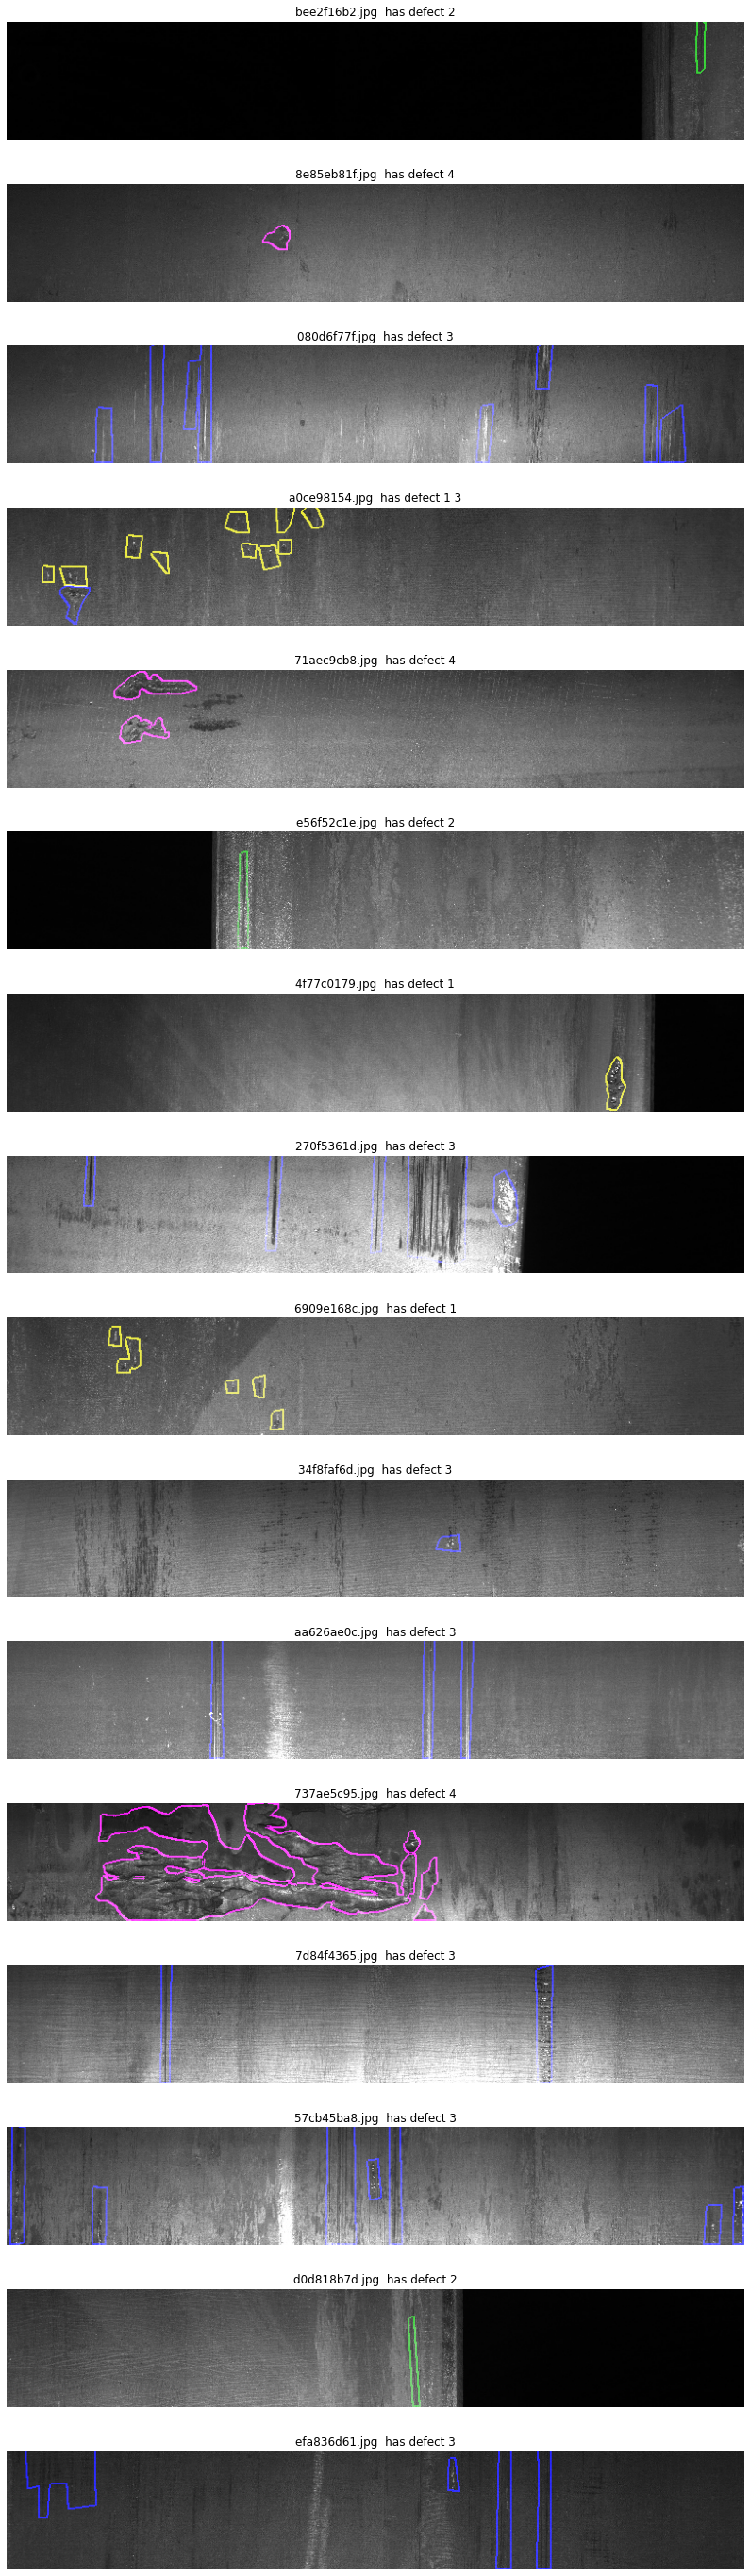

In [12]:
# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    plt.figure(figsize=(14,50)) #20,18
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [13]:
!pip install segmentation-models

In [14]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Compute Dice Coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [15]:
from segmentation_models import Unet

Segmentation Models: using `keras` framework.


In [34]:
from segmentation_models import FPN
from segmentation_models import Linknet
from segmentation_models import PSPNet

Segmentation Models: using `keras` framework.


In [85]:
# Load U-Net pretrained from ImageNet
model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

In [16]:
# LOAD MODEL
from keras.models import load_model
model = load_model('/kaggle/input/models/UNETresnet34.h5',custom_objects={'dice_coef':dice_coef})

In [17]:
idx = int(0.8*len(train2)); print()


In [ ]:
# Train and validate the model
# idx = int(0.8*len(train2)); print()
# train_batches = DataGenerator(train2.iloc[:idx],shuffle=True)
# valid_batches = DataGenerator(train2.iloc[idx:])
# history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=2)

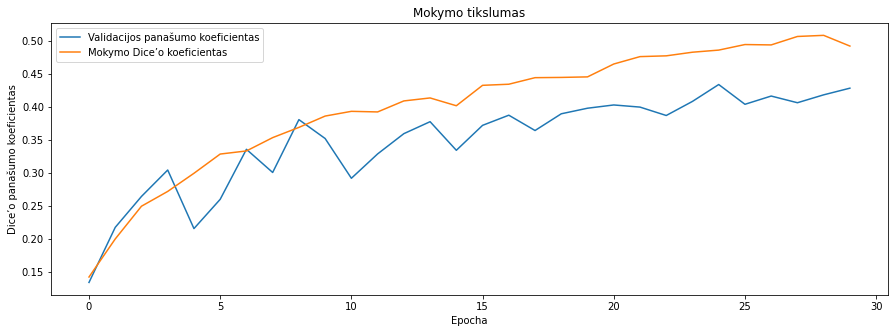

In [40]:
# Plot training
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Validacijos panašumo koeficientas')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Mokymo Dice’o koeficientas')
plt.title('Mokymo tikslumas'); plt.xlabel('Epocha'); plt.ylabel('Dice’o panašumo koeficientas');plt.legend(); 
plt.show()

In [18]:
# PREDICT FROM VALIDATION SET
val_set = train2.iloc[idx:];
defects = list(val_set[val_set['e1']!=''].sample(6).index)
defects += list(val_set[val_set['e2']!=''].sample(6).index)
defects += list(val_set[val_set['e3']!=''].sample(14).index)
defects += list(val_set[val_set['e4']!=''].sample(6).index)

valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
preds = model.predict_generator(valid_batches,verbose=1)

2/2 [==============================] - 5s 2s/step


Raktai: geltona=defektas 1, žalia=defektas 2, mėlyna=defektas 3, violetinė=defektas 4


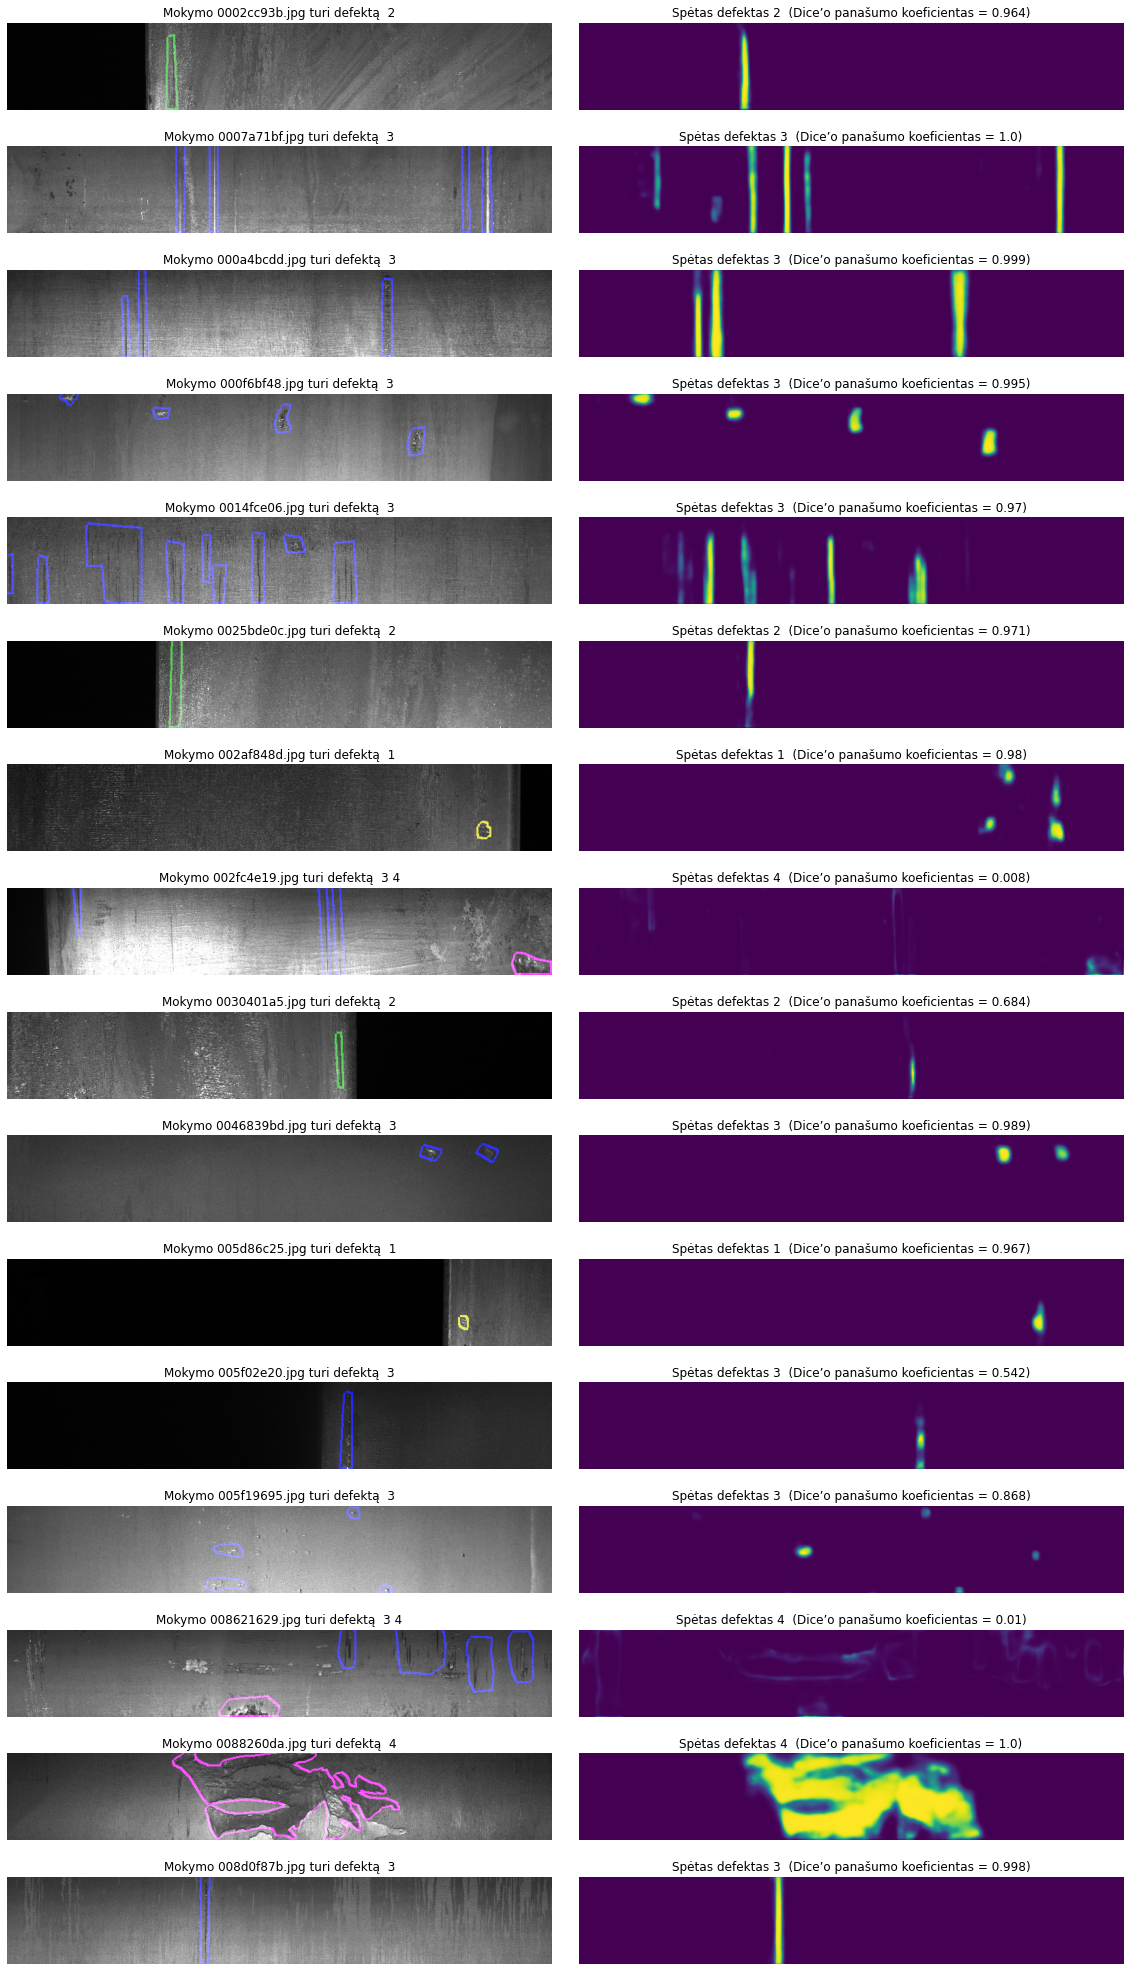

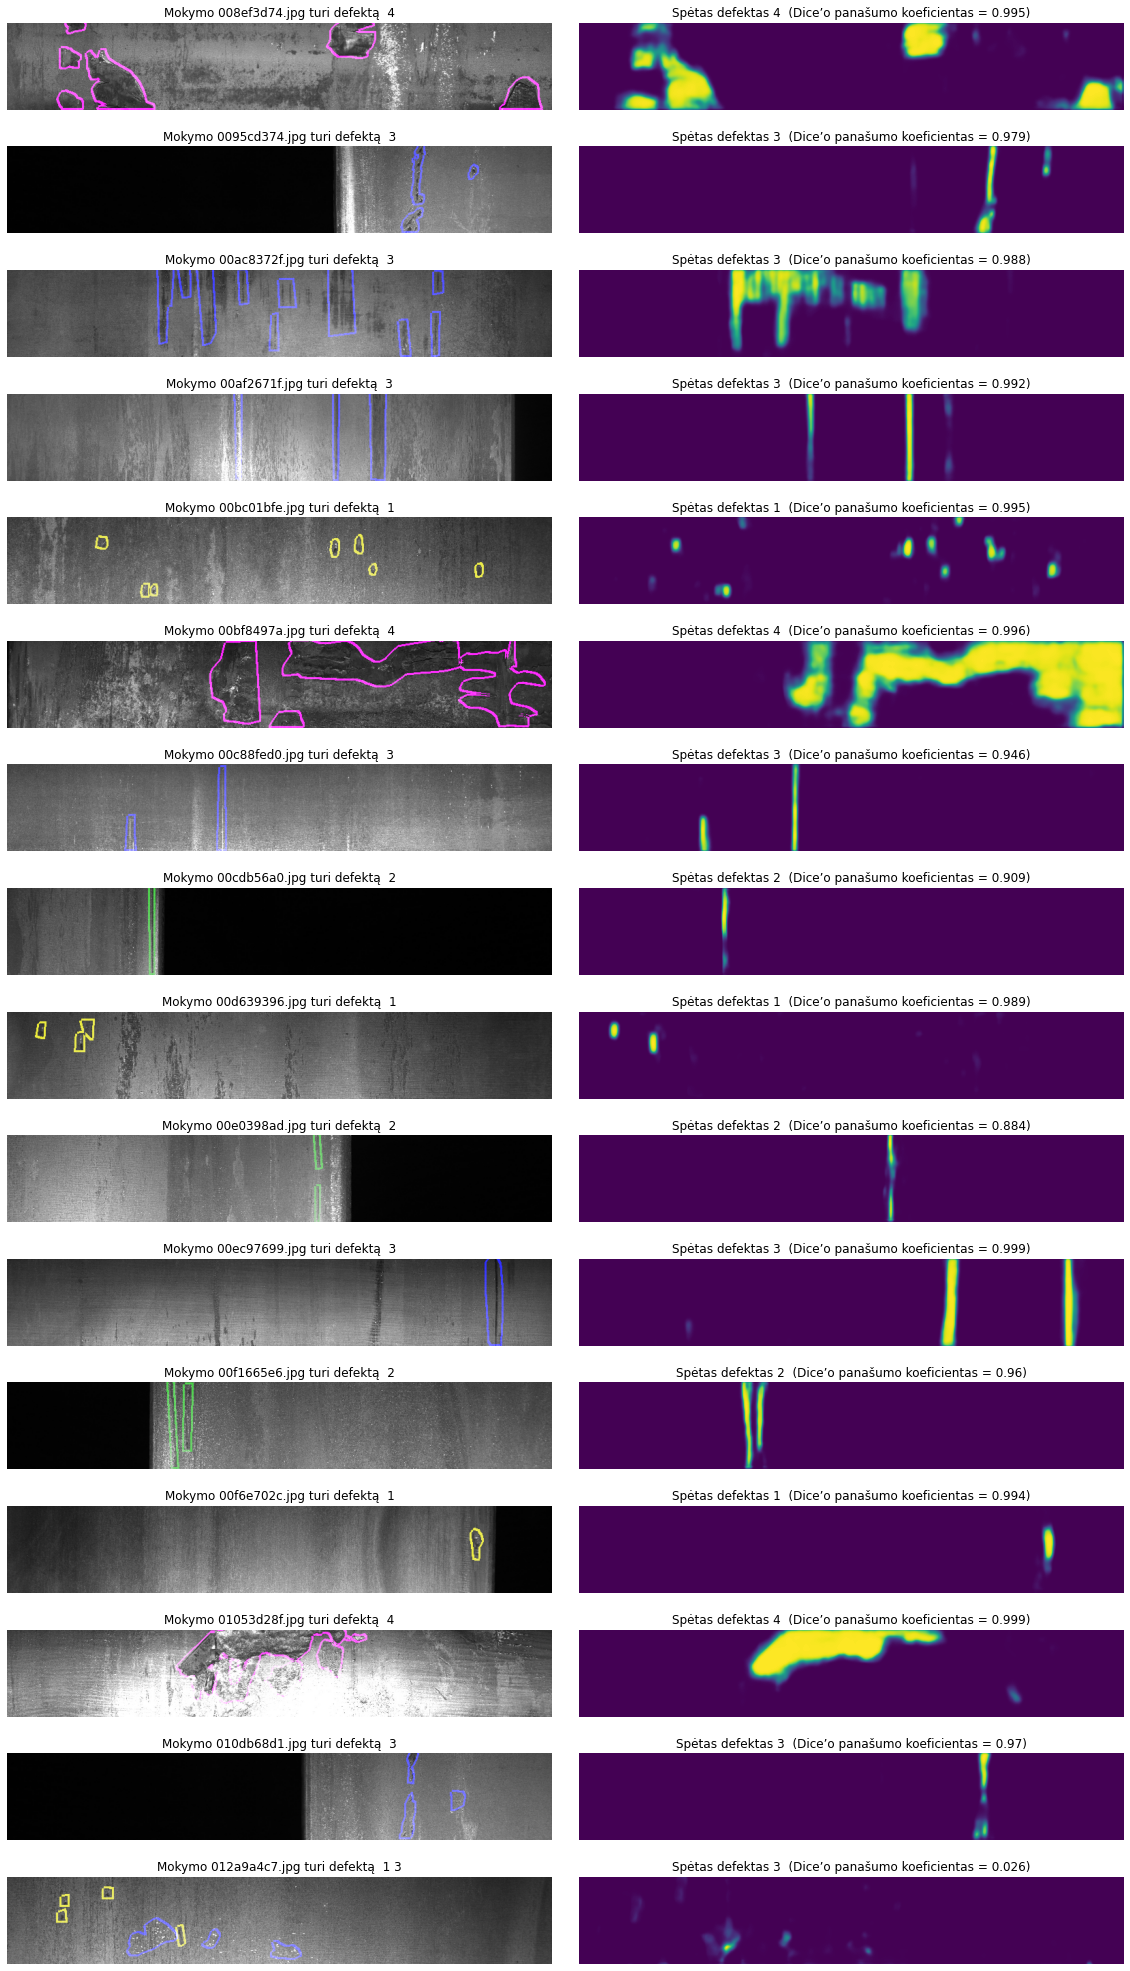

In [19]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
print('Raktai: geltona=defektas 1, žalia=defektas 2, mėlyna=defektas 3, violetinė=defektas 4')

for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        extra = ' turi defektą '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        if extra=='  turi defektą ': extra =''
        plt.title('Mokymo '+train2.iloc[16*i+k,0]+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        if dft!=0:
            msk = preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((96,768)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title('Spėtas defektas '+str(dft)+'  (Dice’o panašumo koeficientas = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [20]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS 1, 2, 4)
val_set = train2.iloc[idx:]
val_set2 = val_set[(val_set['count']!=0)&(val_set['e3']=='')].sample(16)

valid_batches = DataGenerator(val_set2)
preds = model.predict_generator(valid_batches,verbose=1)

1/1 [==============================] - 0s 375ms/step


Raktai: geltona=defektas 1, žalia=defektas 2, mėlyna=defektas 3, violetinė=defektas 4


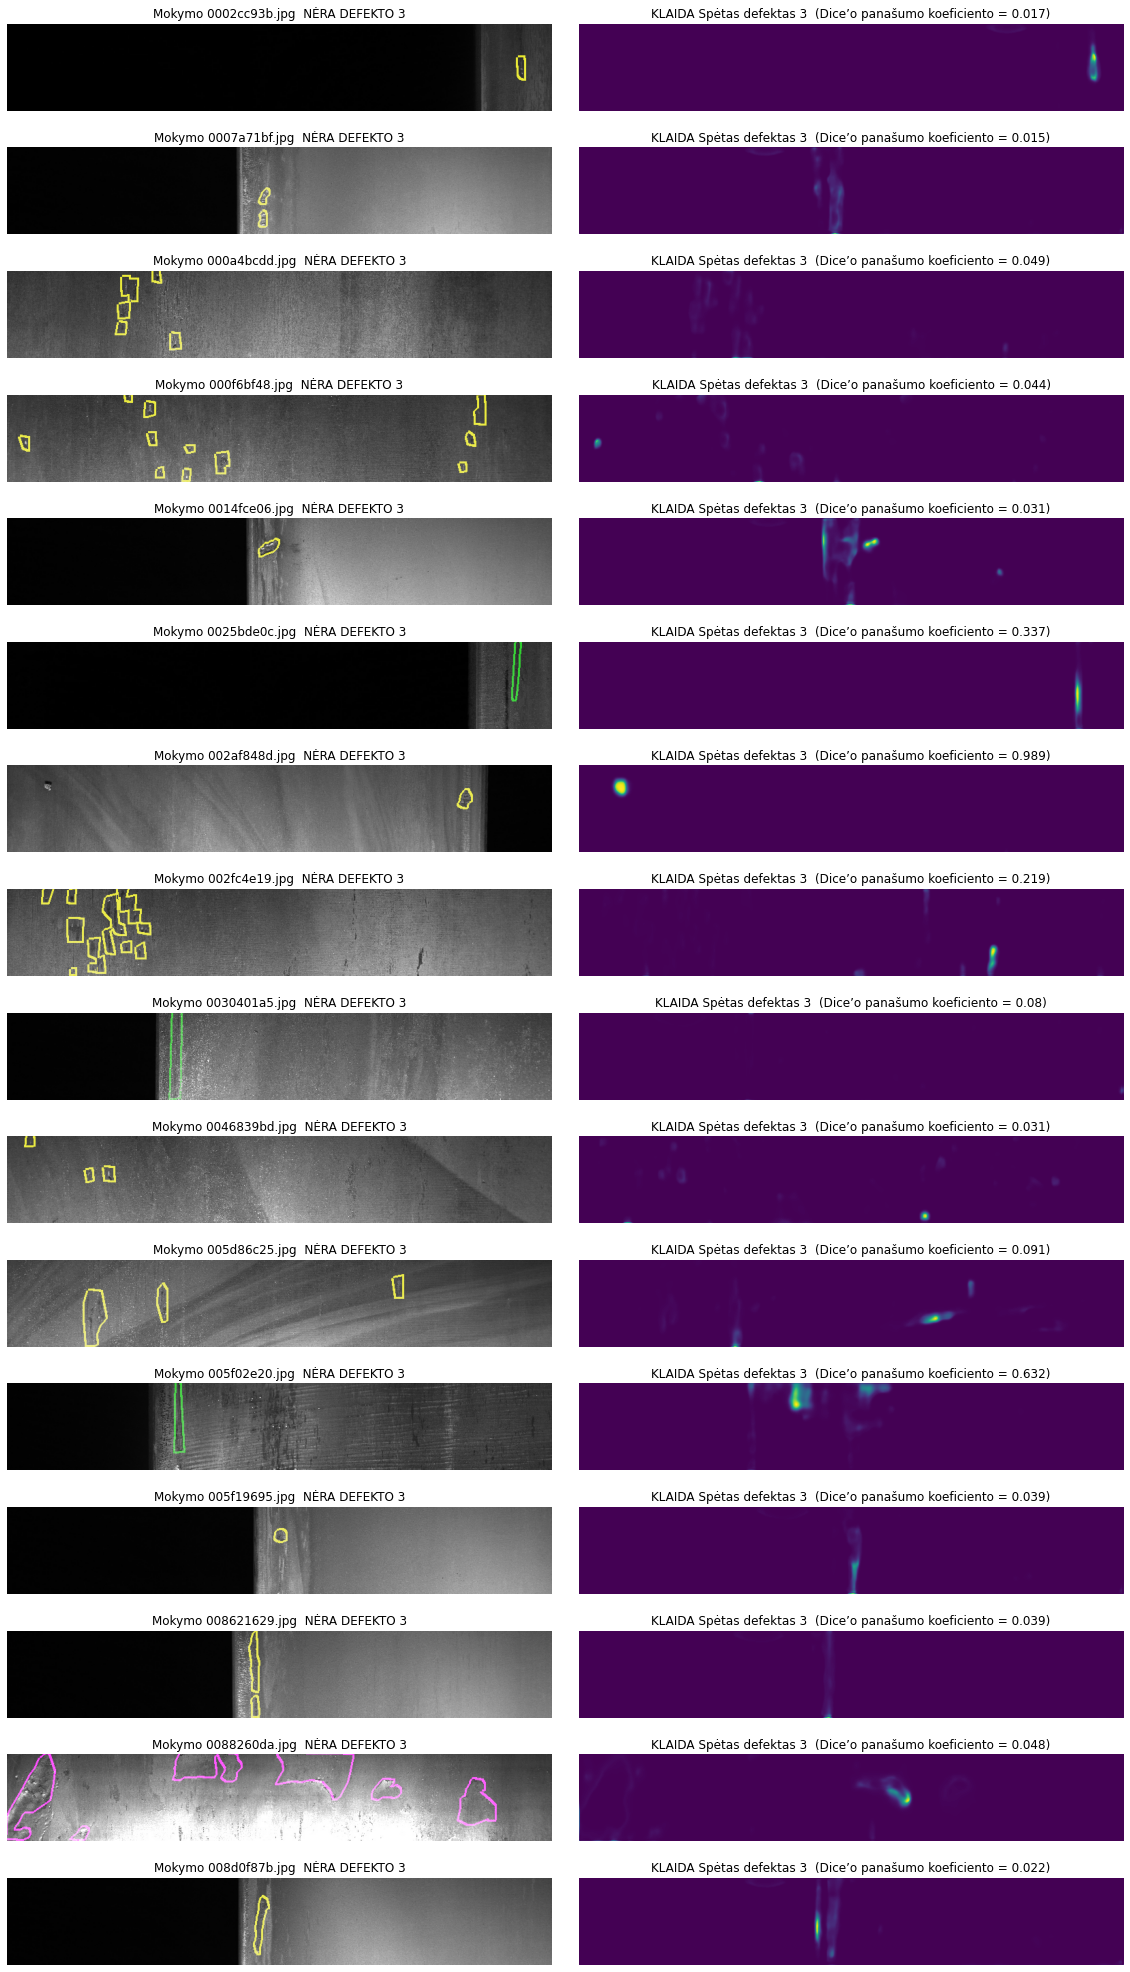

In [22]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set2)
print('Raktai: geltona=defektas 1, žalia=defektas 2, mėlyna=defektas 3, violetinė=defektas 4')
for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        three = False
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if (j==2)&(np.sum(msk)!=0): 
                three=np.sum(msk)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        extra = ''; extra2 = ''
        if not three: 
            extra = 'NĖRA DEFEKTO 3'
            extra2 = 'KLAIDA '
        plt.title('Mokymo '+train2.iloc[16*i+k,0]+'  '+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        dft=3
        if dft!=0:
            msk = preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((144,816)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title(extra2+'Spėtas defektas '+str(dft)+'  (Dice’o panašumo koeficiento = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

U-Net išveda
kaukes, naudodamas visas slankiojo kablelio reikšmes nuo 0 iki 1 imtinai. Šiai klasifikavimo prob-
lemai spręsti reikia naudoti tik sveikuosius skaičius 0 ir 1. Todėl kaukes su slankiojo kablelio
reikšmėmis turi būti paverstos sveikaisiais skaičiais naudojant ribą. Jei pikselis >= riba, tuomet
pikseliui priskiriama reikšmė 1, kitu atveju pikseliui priskiriama reikšmė 0. Tai reiškia, kad jei riba
yra maža, tada užtikrintumas, kad toje vietoje yra defektas nėra didelis, o jei riba didelė, tada atitin-
kamai užtikrintumas, kad toje vietoje yra defektas, didelis

In [23]:
# PREDICT FROM VALIDATION SET (USE ALL)
valid_batches = DataGenerator(train2.iloc[idx:])
preds = model.predict_generator(valid_batches,verbose=1)

83/83 [==============================] - 23s 277ms/step


RIBA = 0.1 pavaizduota žemiau


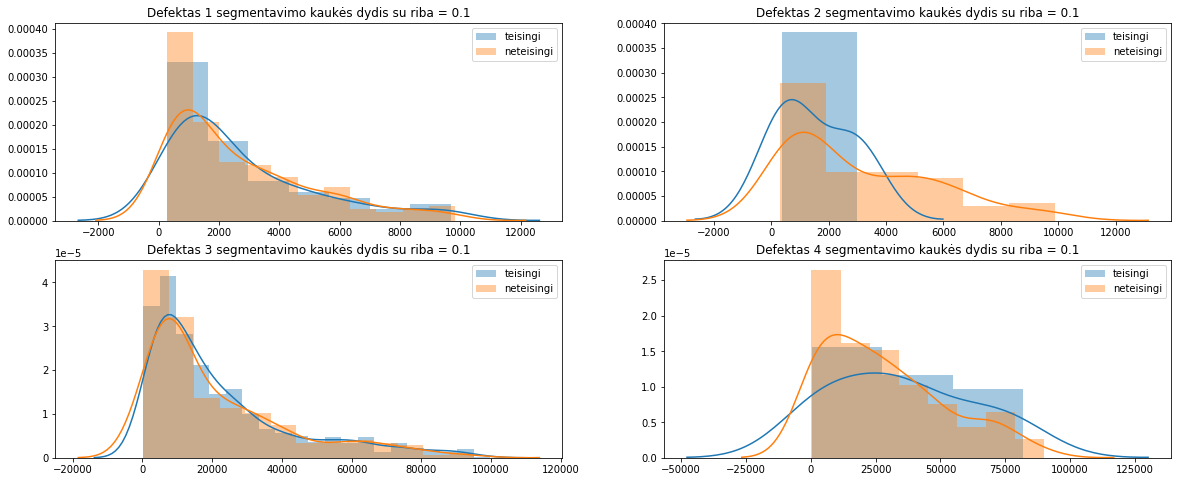

Su riba = 0.1 , defektas 1 turi 73 teisingų ir 397 neteisingų segmentavimo kaukių
Su riba = 0.1 , defektas 2 turi 5 teisingų ir 111 neteisingų segmentavimo kaukių
Su riba = 0.1 , defektas 3 turi 826 teisingų ir 256 neteisingų segmentavimo kaukių
Su riba = 0.1 , defektas 4 turi 20 teisingų ir 175 neteisingų segmentavimo kaukių

RIBA = 0.25 pavaizduota žemiau


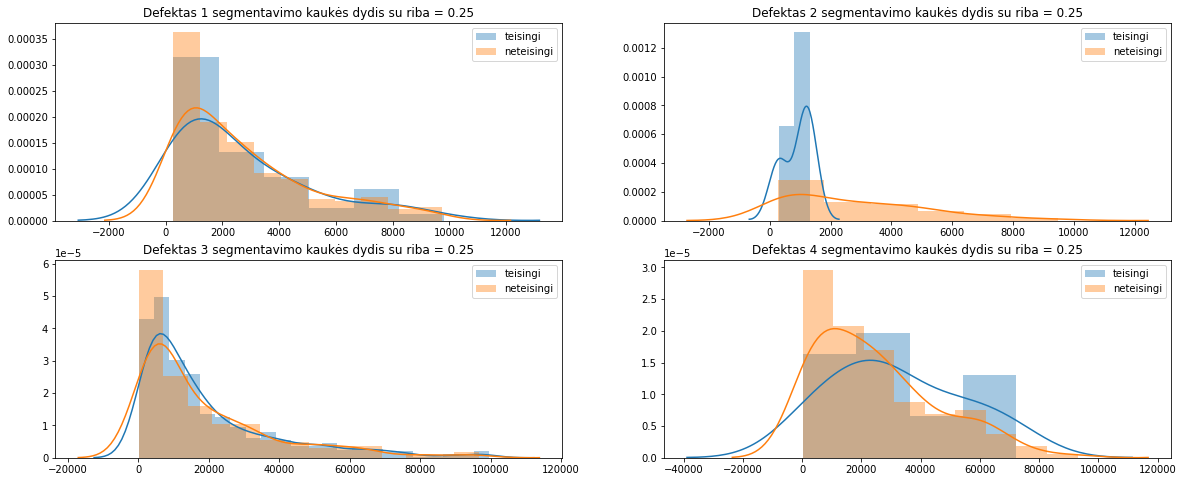

Su riba = 0.25 , defektas 1 turi 57 teisingų ir 303 neteisingų segmentavimo kaukių
Su riba = 0.25 , defektas 2 turi 3 teisingų ir 87 neteisingų segmentavimo kaukių
Su riba = 0.25 , defektas 3 turi 800 teisingų ir 248 neteisingų segmentavimo kaukių
Su riba = 0.25 , defektas 4 turi 18 teisingų ir 163 neteisingų segmentavimo kaukių

RIBA = 0.5 pavaizduota žemiau


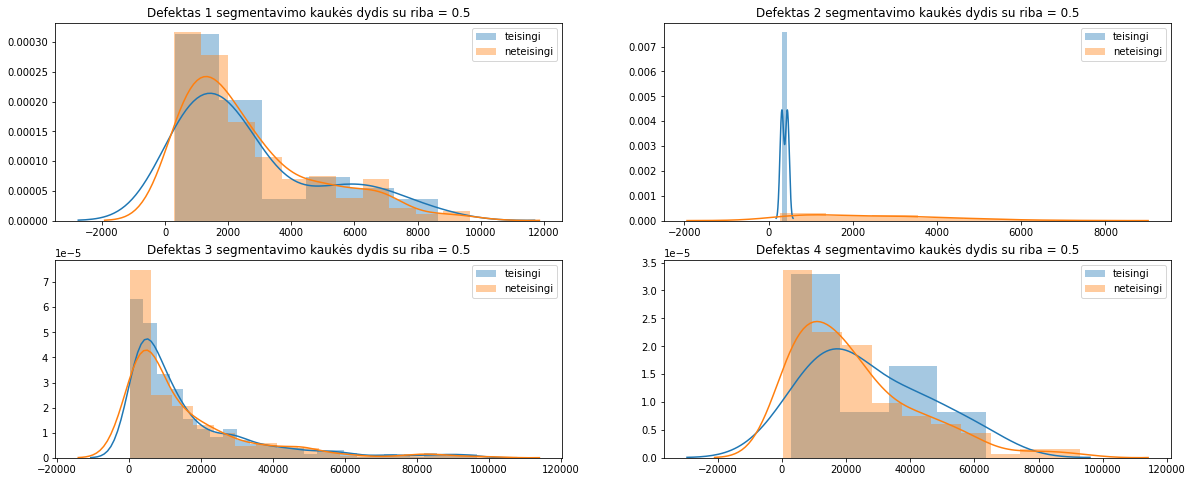

Su riba = 0.5 , defektas 1 turi 40 teisingų ir 223 neteisingų segmentavimo kaukių
Su riba = 0.5 , defektas 2 turi 2 teisingų ir 63 neteisingų segmentavimo kaukių
Su riba = 0.5 , defektas 3 turi 764 teisingų ir 235 neteisingų segmentavimo kaukių
Su riba = 0.5 , defektas 4 turi 17 teisingų ir 150 neteisingų segmentavimo kaukių

RIBA = 0.75 pavaizduota žemiau


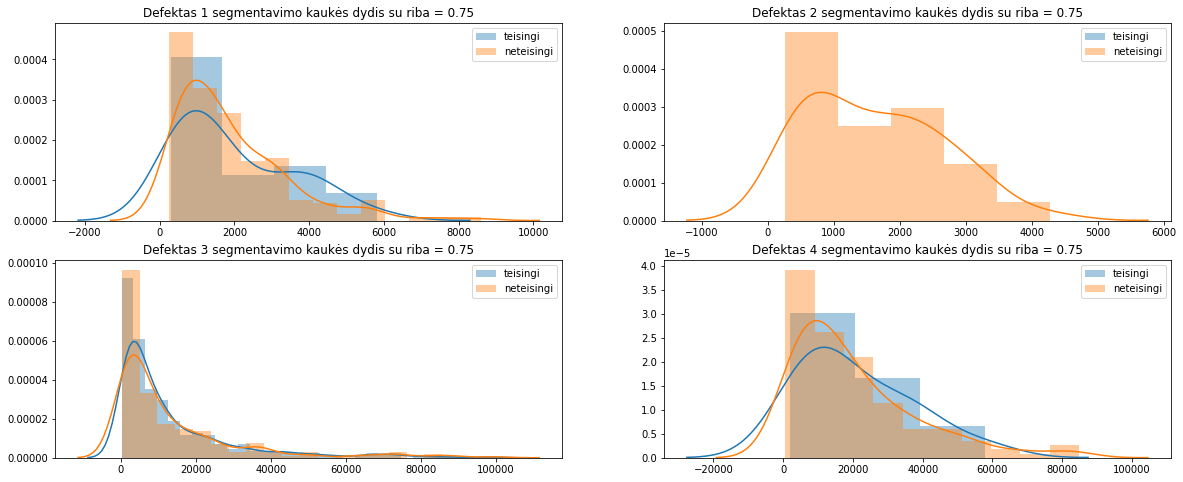

Su riba = 0.75 , defektas 1 turi 32 teisingų ir 180 neteisingų segmentavimo kaukių
Su riba = 0.75 , defektas 2 turi 0 teisingų ir 50 neteisingų segmentavimo kaukių
Su riba = 0.75 , defektas 3 turi 722 teisingų ir 221 neteisingų segmentavimo kaukių
Su riba = 0.75 , defektas 4 turi 17 teisingų ir 139 neteisingų segmentavimo kaukių

RIBA = 0.9 pavaizduota žemiau


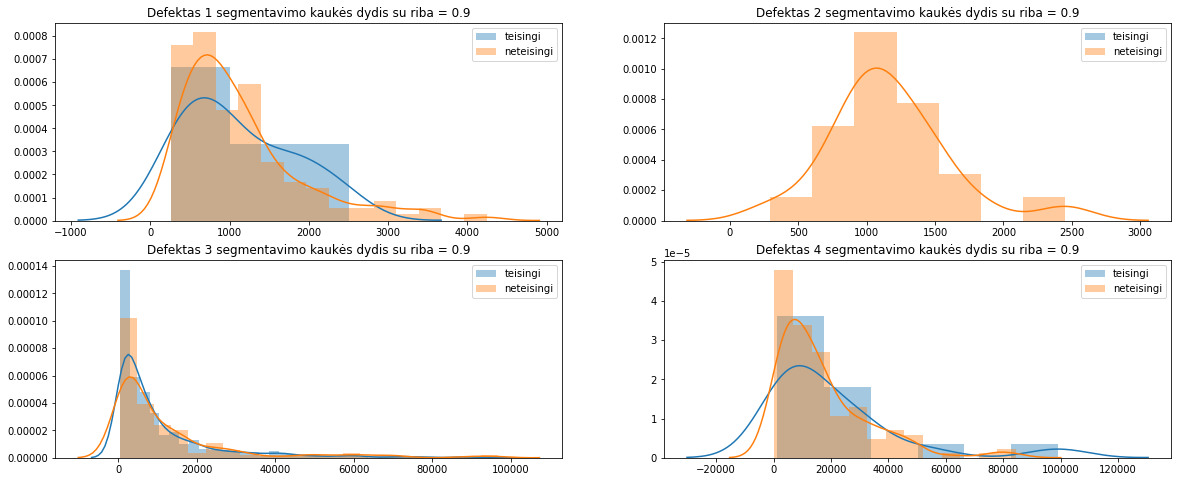

Su riba = 0.9 , defektas 1 turi 24 teisingų ir 125 neteisingų segmentavimo kaukių
Su riba = 0.9 , defektas 2 turi 0 teisingų ir 21 neteisingų segmentavimo kaukių
Su riba = 0.9 , defektas 3 turi 663 teisingų ir 194 neteisingų segmentavimo kaukių
Su riba = 0.9 , defektas 4 turi 17 teisingų ir 133 neteisingų segmentavimo kaukių



In [24]:
# PLOT RESULTS
import seaborn as sns
pix_min = 250
for THRESHOLD in [0.1, 0.25, 0.50, 0.75, 0.9]:
    print('RIBA =',THRESHOLD,'pavaizduota žemiau')
    correct=[[],[],[],[]]; incorrect=[[],[],[],[]]
    for i,f in enumerate(train2.iloc[idx:idx+len(preds)]['ImageId']):
        preds2 = preds[i].copy()
        preds2[preds2>=THRESHOLD]=1
        preds2[preds2<THRESHOLD]=0
        sums = np.sum(preds2,axis=(0,1))
        for j in range(4):
            if 4*sums[j]<pix_min: continue
            if train2.iloc[i,j+1]=='': incorrect[j].append(4*sums[j])
            else: correct[j].append(4*sums[j])
    plt.figure(figsize=(20,8))
    for j in range(4):
        limit = [10000,10000,100000,100000][j]
        plt.subplot(2,2,j+1)
        sns.distplot([x for x in correct[j] if x<limit], label = 'teisingi')
        sns.distplot([x for x in incorrect[j] if x<limit], label = 'neteisingi')
        plt.title('Defektas '+str(j+1)+' segmentavimo kaukės dydis su riba = '+str(THRESHOLD)); plt.legend()
    plt.show()
    for j in range(4):
        c1 = np.array(correct[j])
        c2 = np.array(incorrect[j])
        print('Su riba =',THRESHOLD,', defektas',j+1,'turi',len(c1[c1!=0]),'teisingų ir',len(c2[c2!=0]),'neteisingų segmentavimo kaukių')
    print()

In [52]:
# # SAVE MODEL
# model.save('PSPNetresnet34epoch30.h5')

In [ ]:
# # SAVE MODEL
# model.save('UNETresnet101.h5')

# # LOAD MODEL
# from keras.models import load_model
# model = load_model('UNETresnet101.h5',custom_objects={'dice_coef':dice_coef})
